# Flight Delay Classifier v3
This go round, the goal is to do everything I did correclty in v2, but make it cleaner and easier to read. I am also going to be pairing this with my medium write-ups so I will need to make sure I can easily process the data with or without the weather features as that will come in a later post. That means making changes like:
* Dropping all unnecessary features from the get-go.
* Training and evaluating models in discrete sections that are easily compared.
* Writing up proper conclusions at the end.
* Using the first person singular instead of the first person plural because I am not royalty.

In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration
### Loading the Data
My first step is to physically load the data. Since last time, I have aggregated all of the flight info for PDX into a single file containing every carrier's data. I will load this and the weather data into two dataframes.

In [2]:
delay_df = pd.read_csv('data/delays/concatenated_delays/PDX_delays.csv')
weather_df = pd.read_csv('data/weather/PDX_weather.csv')

In [3]:
delay_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594126 entries, 0 to 594125
Data columns (total 18 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Unnamed: 0                                594126 non-null  int64  
 1   Carrier Code                              594126 non-null  object 
 2   Date (MM/DD/YYYY)                         594126 non-null  object 
 3   Flight Number                             594126 non-null  float64
 4   Tail Number                               593220 non-null  object 
 5   Destination Airport                       594126 non-null  object 
 6   Scheduled departure time                  594126 non-null  object 
 7   Actual departure time                     594126 non-null  object 
 8   Scheduled elapsed time (Minutes)          594126 non-null  float64
 9   Actual elapsed time (Minutes)             594126 non-null  float64
 10  Departure delay (Min

In [4]:
delay_df['Date (MM/DD/YYYY)'] = pd.to_datetime(delay_df['Date (MM/DD/YYYY)'])
delay_df['Scheduled departure time'] = pd.to_datetime(delay_df['Scheduled departure time'], format='%H:%M')
delay_df[['Date (MM/DD/YYYY)', 'Departure delay (Minutes)', 'Scheduled departure time']].describe()

,Date (MM/DD/YYYY),Departure delay (Minutes),Scheduled departure time
count,594126,594126.000000,594126
mean,2023-07-07 13:59:46.839154944,10.814613,1900-01-01 13:23:25.213742848
min,2021-01-01 00:00:00,-60.000000,1900-01-01 00:04:00
25%,2022-05-20 00:00:00,-4.000000,1900-01-01 09:00:00
50%,2023-07-29 00:00:00,0.000000,1900-01-01 13:10:00
75%,2024-09-02 00:00:00,11.000000,1900-01-01 17:35:00
max,2025-09-30 00:00:00,3024.000000,1900-01-01 23:59:00
std,NaN,39.733229,NaN


In [5]:
dup_cols = ['Carrier Code', 'Date (MM/DD/YYYY)', 'Flight Number', 'Scheduled departure time']
print(f'Before dropping duplicates: {len(delay_df)} rows.')
delay_df.drop_duplicates(inplace=True)
print(f'After dropping duplicates: {len(delay_df)} rows.')

Before dropping duplicates: 594126 rows.
After dropping duplicates: 594035 rows.


In [6]:
print(f'Before dropping > 24 hour delays: {len(delay_df)} rows.')
delay_df = delay_df[delay_df['Departure delay (Minutes)'] < 24*60]
print(f'After dropping > 24 hour delays: {len(delay_df)} rows.')

Before dropping > 24 hour delays: 594035 rows.
After dropping > 24 hour delays: 594005 rows.


## Examining Possible Features
I will be checking for trends among the features and the target variable--the flight delay status. Other delay variables outside of 'Departure delay (Minutes)' will be ignored as these are just subsets of the total delay.

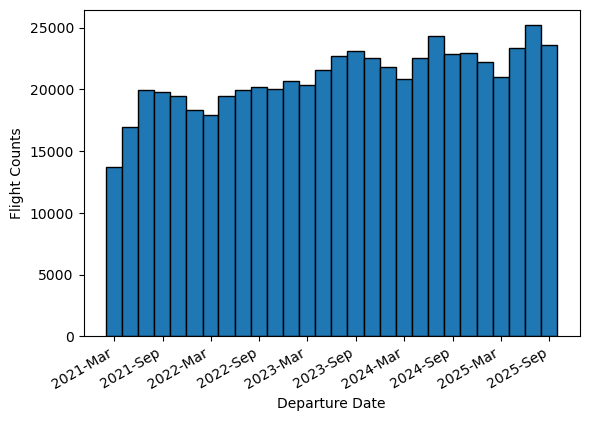

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.dates as mdates
bin_edges = pd.date_range(start=delay_df['Date (MM/DD/YYYY)'].min(), end=delay_df['Date (MM/DD/YYYY)'].max(), freq='2ME')

plt.hist(delay_df['Date (MM/DD/YYYY)'], bins=bin_edges, edgecolor='black')
plt.xlabel('Departure Date')
plt.ylabel('Flight Counts')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.show()
plt.savefig('../../../Downloads/Number_of_Flights_by_Date.png')

In [8]:
delay_df['Delayed'] = np.where(delay_df['Departure delay (Minutes)'] > 0, 1, 0)

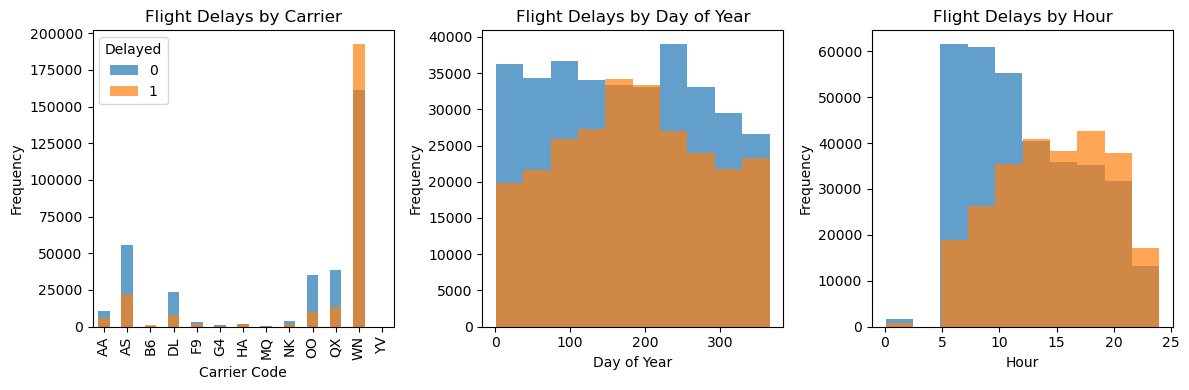

In [9]:
delay_df['DayOfYear'] = delay_df['Date (MM/DD/YYYY)'].dt.dayofyear
delay_df['Hour'] = delay_df['Scheduled departure time'].dt.hour + delay_df['Scheduled departure time'].dt.minute / 60

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
delay_df.groupby(['Carrier Code', 'Delayed']).size().unstack(fill_value=0)[0].plot(
    kind='bar', 
    stacked=True,
    alpha=0.7,
    legend=True,
    title='Flight Delays by Carrier',
    label='0',
    ax=axs[0],
    color='tab:blue'
)
delay_df.groupby(['Carrier Code', 'Delayed']).size().unstack(fill_value=0)[1].plot(
    kind='bar', 
    stacked=True,
    alpha=0.7,
    legend=True,
    label='1',
    ax=axs[0],
    color='tab:orange'
)
axs[0].set_xlabel('Carrier Code')
axs[0].set_ylabel('Frequency')
axs[0].legend(title='Delayed')

delay_df.groupby('Delayed')['DayOfYear'].plot(
    kind='hist',
    stacked=True,
    alpha=0.7,
    bins=10,  # Adjust the number of bins as needed
    # legend=True,
    title='Flight Delays by Day of Year',
    ax=axs[1]
)
axs[1].set_xlabel('Day of Year')
axs[1].set_ylabel('Frequency')

delay_df.groupby('Delayed')['Hour'].plot(
    kind='hist',
    stacked=True,
    alpha=0.7,
    bins=10,  # Adjust the number of bins as needed
    # legend=True,
    title='Flight Delays by Hour',
    ax=axs[2]
)
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../../../Downloads/Delays_by_Carrier_DayOfYear_Hour_PDX.png')

In [10]:
dest_act_df = pd.DataFrame(delay_df.groupby('Destination Airport')['Delayed'].value_counts())
dest_prop_df = pd.DataFrame(delay_df.groupby('Destination Airport')['Delayed'].value_counts(normalize=True))
dest_df = pd.concat([dest_act_df, dest_prop_df], axis=1)
dest_df.columns = ['Count', 'Proportion']
dest_df = dest_df.reset_index()
dest_df = dest_df[dest_df['Delayed'] == 1]
print(dest_df.sort_values(by='Proportion', ascending=False).head(20))

    Destination Airport  Delayed  Count  Proportion
34                  CLE        1      1    1.000000
155                 PBI        1      4    0.800000
157                 PDX        1    365    0.762004
121                 MEM        1   1327    0.647001
105                 LGA        1   3874    0.642029
24                  BUF        1     17    0.629630
127                 MKE        1   1034    0.629337
175                 RDU        1    992    0.625473
179                 RSW        1    570    0.615551
37                  CMH        1   1087    0.613085
45                  DAL        1    339    0.603203
93                  JAX        1    336    0.600000
107                 LGB        1   1433    0.599833
28                  BWI        1   4762    0.594433
119                 MDW        1   7746    0.594018
213                 TPA        1   3499    0.584238
91                  IND        1   1589    0.579082
32                  CHS        1    928    0.573902
159         

In [11]:
tail_no_act_df = pd.DataFrame(delay_df.groupby('Tail Number')['Delayed'].value_counts())
tail_no_prop_df = pd.DataFrame(delay_df.groupby('Tail Number')['Delayed'].value_counts(normalize=True))
tail_no_df = pd.concat([tail_no_act_df, tail_no_prop_df], axis=1)
tail_no_df.columns = ['Count', 'Proportion']
tail_no_df = tail_no_df.reset_index()
tail_no_df = tail_no_df[tail_no_df['Delayed'] == 1].sort_values(by='Proportion', ascending=False)
print(tail_no_df[tail_no_df['Count'] > 20].head(20))

     Tail Number  Delayed  Count  Proportion
2474      N391HA        1     43    0.704918
4751      N745SW        1    113    0.693252
2404      N382HA        1     38    0.678571
6753      N8941Q        1     35    0.673077
4501      N711HK        1     84    0.666667
2450      N388HA        1     41    0.661290
2428      N385HA        1     37    0.660714
4566      N717SA        1     98    0.657718
2436      N386HA        1     44    0.656716
6763      N8946L        1     40    0.655738
2513      N396HA        1     34    0.653846
6431      N8808Q        1    313    0.653445
2388      N380HA        1     30    0.652174
6761      N8945Q        1     33    0.647059
6425      N8805L        1    309    0.646444
6423      N8804L        1    307    0.643606
6743      N8938Q        1     32    0.640000
6177      N8707P        1    220    0.639535
6789      N8957Q        1     23    0.638889
6781      N8953Q        1     23    0.638889


## Collinearity
Given the large chi-squared value between 'Flight Number' and 'Destination Airport', I am inclined to follow my intuition that these two variables are correlated. The 'Flight Number' is thus unlikely to add additional detail to the model that isn't already captured in 'Destination Airport' (and likely other features as well).

In [12]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(delay_df['Flight Number'], delay_df['Destination Airport'])

chi2_statistic, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f'\nChi-squared Statistic: {chi2_statistic}')
print(f'P-value: {p_value}')


Chi-squared Statistic: 25069241.64547756
P-value: 0.0


# Data Cleaning
## Reducing Dimensionality
I will immediately be dropping features from the dataframe that did not pass the "smell test" from the data exploration. Additionally, I am keeping the date column so that I can split by time for training and test data to avoid leakage. 

In [13]:
delay_df = delay_df[['Carrier Code', 'DayOfYear', 'Hour', 'Destination Airport', 'Tail Number', 'Delayed', 'Date (MM/DD/YYYY)']]
delay_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594005 entries, 0 to 594125
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Carrier Code         594005 non-null  object        
 1   DayOfYear            594005 non-null  int32         
 2   Hour                 594005 non-null  float64       
 3   Destination Airport  594005 non-null  object        
 4   Tail Number          593099 non-null  object        
 5   Delayed              594005 non-null  int64         
 6   Date (MM/DD/YYYY)    594005 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 34.0+ MB


## NaN Checks
Many of the machine learning models I will be testing cannot natively handle NaN values so I'll need to make sure to identify NaNs and either drop or replace them appropriately. Since there are only NaN values in the Tail Number feature, it simplifies my approach. Dropping the rows with NaNs would be acceptable since there are so few relative to the total number of data points, but I can do better in this instance. I will fill the values based on the most common value shared by similar rows. For instance, if Tail Number is NaN, I would fill it with the most common Tail Number from rows with the same Carrier Code and Destination Airport.

In [14]:
delay_df.isna().sum()

Carrier Code             0
DayOfYear                0
Hour                     0
Destination Airport      0
Tail Number            906
Delayed                  0
Date (MM/DD/YYYY)        0
dtype: int64

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class GroupedModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col):
        self.group_cols = group_cols
        self.target_col = target_col
        self.impute_map_ = None
        self.global_mode_ = None

    def fit(self, X, y=None):
        # Calculate mode for each group. Use 'Unknown' if there is no mode
        self.impute_map_ = X.groupby(self.group_cols)[self.target_col].apply(
            lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
        ).to_dict()
        self.n_features_in_ = X.shape[1]
        
        return self

    def transform(self, X):
        check_is_fitted(self)
        
        # Create a key for mapping groups and then fill na values
        group_keys = X[self.group_cols].apply(tuple, axis=1)        
        mask = X[self.target_col].isna()        
        X.loc[mask, self.target_col] = group_keys[mask].map(self.impute_map_)

        assert self.n_features_in_ == X.shape[1]
        return X

    def get_feature_names_out(self, input_features=None):
        # Define how feature names are transformed
        out = [f'{col}' for col in self.group_cols]
        out.append(f'{self.target_col}')
        return out

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

impute_tail = GroupedModeImputer(group_cols=['Carrier Code', 'Destination Airport'], target_col='Tail Number')

cat_pipeline = Pipeline([
    ('fill_tail', impute_tail),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

## Cyclic Transformations of DayOfYear and Hour
To ensure that neighboring days and hours are treated similarly even when the values appear far apart (e.g. 2300 and 0100), I will transform them with sine and cosine. This will ensure that the cyclic nature of the data is preserved and appropriately incorporated by the models.

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.validation import check_array, check_is_fitted

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# sine and cosine transformer classes to be used for date and time variables
class SinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.sin(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_sin' for col in input_features]

class CosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.cos(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_cos' for col in input_features]

## Column Transformer
Finally, toss the categorical pipeline and cyclic transformers into a column transformer to make sure it can be easily run on the data.

In [18]:
from sklearn.compose import ColumnTransformer

cat_cols = ['Carrier Code', 'Destination Airport', 'Tail Number']
date_cols = ['DayOfYear']
time_cols = ['Hour']
feature_transformer = ColumnTransformer(
    transformers=[
        ('categorical', cat_pipeline, cat_cols),
        ('day_sin', SinTransformer(365), date_cols),
        ('day_cos', CosTransformer(365), date_cols),
        ('hour_sin', SinTransformer(24), time_cols),
        ('hour_cos', CosTransformer(24), time_cols),
    ]
)

# Testing Machine Learning Models
Now is finally the time to test out some machine learning algorithms on the data. I will be testing 4 models:
1. Logistic regression
2. Nonlinear SVM
3. Random forest
4. Neural network.

These generally proceed from less complex to more complex with the hope being that there will be an optimum where model complexity meets accuracy. And to give each model the best chance at success, I will be optimizing hyperparameters with RandomizedSearchCV when possible.

## Splitting Training and Test Data
The first step is to, naturally, split the data into a test set and a training set to avoid leakage and overfitting issues. To prevent data leakage, I will be using the first ~3.75 years as the training data and the final year as the test data yielding a roughly 80%-20% split in the data.

In [19]:
cutoff_date = delay_df['Date (MM/DD/YYYY)'].max() - pd.offsets.DateOffset(years=1)
train = delay_df[delay_df['Date (MM/DD/YYYY)'] < cutoff_date]
test = delay_df[delay_df['Date (MM/DD/YYYY)'] >= cutoff_date]

X_train = train.drop(['Delayed', 'Date (MM/DD/YYYY)'], axis=1)
y_train = train['Delayed']
X_test = test.drop(['Delayed', 'Date (MM/DD/YYYY)'], axis=1)
y_test = test['Delayed']

print(len(X_train) / (len(X_train) + len(X_test)))

0.7671551586266109


## Logistic Regression
Logistic regression is the fundamental classifier, in a sense, making it an ideal starting point for testing. I will create a pipeline from the ColumnTransformer above and the logistic regression function so that it can quickly crank through the training data and be easily reused when more data is available in future iterations. 

In [20]:
from scipy.stats import loguniform, uniform
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV

logistic_pipeline = Pipeline([
    ('data_transformer', feature_transformer),
    ('logistic_clf', SGDClassifier(loss='log_loss', penalty='elasticnet', n_jobs=-1)) # log_loss makes it a logistic regression
])

logistic_param_distribs = {'logistic_clf__alpha': loguniform(1e-6, 1),
                  'logistic_clf__l1_ratio': uniform(loc=0., scale=1.)}
logistic_search = RandomizedSearchCV(logistic_pipeline, param_distributions=logistic_param_distribs, 
                                n_iter=100, cv=3, n_jobs=-1, scoring='balanced_accuracy')
logistic_search.fit(X_train, y_train.values.ravel())

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lasticnet'))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'logistic_clf__alpha': <scipy.stats....001B1E9E12900>, 'logistic_clf__l1_ratio': <scipy.stats....001B1E9E6D090>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... vers

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_logistic_model = logistic_search.best_estimator_
logistic_pred = best_logistic_model.predict(X_test)
logistic_results = {'Accuracy': accuracy_score(y_test, logistic_pred),
                    'Precision': precision_score(y_test, logistic_pred),
                    'Recall': recall_score(y_test, logistic_pred),
                    'F1': f1_score(y_test, logistic_pred)}
print(logistic_results)

{'Accuracy': 0.5967421246321696, 'Precision': 0.5023751125461827, 'Recall': 0.5770581836985789, 'F1': 0.5371330882413962}


## Nonlinear SVM
Next up is a nonlinear support vector machine. Given the uncertain nature of the decision boundary, I will be using rbf since some distance similarity bewteen data points is likely to reveal some underlying structure (e.g. the same destination airport by the same carrier should be more similar than one with a different airport and carrier).

In [35]:
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ('data_transformer', feature_transformer),
    ('svm_clf', SVC(kernel='rbf', max_iter=2000)) # radial basis function kernel
])

svm_param_distribs = {'svm_clf__C': uniform(loc=0., scale=1.),
                      'svm_clf__gamma': loguniform(1e-6, 1)}
svm_search = RandomizedSearchCV(svm_pipeline, param_distributions=svm_param_distribs, 
                                n_iter=30, cv=3, n_jobs=-1, scoring='balanced_accuracy')
svm_search.fit(X_train, y_train.values.ravel())

C:\Users\Dan\anaconda3\envs\pytorch-env\Lib\site-packages\sklearn\svm\_base.py:313: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=2000))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'svm_clf__C': <scipy.stats....0012680CFADD0>, 'svm_clf__gamma': <scipy.stats....0012680CFA350>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",30
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 

In [36]:
best_svm_model = svm_search.best_estimator_
svm_pred = best_svm_model.predict(X_test)
svm_results = {'Accuracy': accuracy_score(y_test, svm_pred),
                    'Precision': precision_score(y_test, svm_pred),
                    'Recall': recall_score(y_test, svm_pred),
                    'F1': f1_score(y_test, svm_pred)}
print(svm_results)

{'Accuracy': 0.5799900224855579, 'Precision': 0.4833291884274227, 'Recall': 0.5198195467270555, 'F1': 0.5009106842159524}


## Random Forest
Now on to an ensemble method: the random forest. This group of decision trees should be able to pare down to the features that are most important.

In [22]:
import gc

del logistic_search
del best_logistic_model

gc.collect()

94

In [24]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

def train_forest():
    rnd_forest_pipeline = Pipeline([
        ('data_transformer', feature_transformer),
        ('rnd_forest_clf', RandomForestClassifier(criterion='gini', n_jobs=-1))
    ])
    
    # We will be tuning our decision tree
    param_distribs = {'rnd_forest_clf__min_samples_split': randint(low=10, high=30),
                      'rnd_forest_clf__min_samples_leaf': randint(low=10, high=30),
                      'rnd_forest_clf__max_leaf_nodes': randint(low=100, high=300),
                      'rnd_forest_clf__max_depth': randint(low=10, high=30),
                      'rnd_forest_clf__max_features': randint(low=100, high=300)}
    rnd_forest_search = RandomizedSearchCV(rnd_forest_pipeline, param_distributions=param_distribs, 
                                    n_iter=60, cv=3, scoring='balanced_accuracy')
    rnd_forest_search.fit(X_train, y_train.values.ravel())

    return rnd_forest_search.best_estimator_

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_forest_model = train_forest()
forest_pred = best_forest_model.predict(X_test)
forest_results = {'Accuracy': accuracy_score(y_test, forest_pred),
               'Precision': precision_score(y_test, forest_pred),
               'Recall': recall_score(y_test, forest_pred),
               'F1': f1_score(y_test, forest_pred)}
print(forest_results)

{'Accuracy': 0.6704528200938464, 'Precision': 0.6088344423025102, 'Recall': 0.5237424439649793, 'F1': 0.5630919059852}


## Aside: Most Important Features
If we take a moment to explore the most important features from the random forest classifier, there are some interesting pieces of information. First, the date and time feature prominently in the top 10 most important features, which is to be expected. Next, there are several carriers that seem to be important for classifying a flight as on-time or delayed. It is not surprising that SouthWest featuers most prominently given its large proportion of delayed flights. Finally, the destination airport does factor in although that appears to be nearly an order of magnitude less important than the day, time, and carrier, in most instances.

In [26]:
# Use the name given in the 'steps' list ('preprocessor' in this case)
feature_names = best_forest_model.named_steps['data_transformer'].get_feature_names_out(input_features=X_train.columns)
rnd_forest_importances = best_forest_model.named_steps['rnd_forest_clf'].feature_importances_
feature_importances_series = pd.Series(rnd_forest_importances, index=feature_names).sort_values(ascending=False)

print(feature_importances_series[:15])

categorical__Carrier Code_WN            0.281515
hour_sin__Hour_sin                      0.200593
categorical__Carrier Code_AS            0.093664
hour_cos__Hour_cos                      0.064638
categorical__Carrier Code_OO            0.059814
categorical__Carrier Code_QX            0.057196
categorical__Destination Airport_SEA    0.044340
categorical__Carrier Code_DL            0.028912
day_cos__DayOfYear_cos                  0.022718
categorical__Destination Airport_MDW    0.009551
categorical__Destination Airport_LGA    0.009378
day_sin__DayOfYear_sin                  0.008862
categorical__Destination Airport_GEG    0.007694
categorical__Destination Airport_BOI    0.006444
categorical__Carrier Code_AA            0.005622
dtype: float64


In [58]:
forest_report = classification_report(y_test, forest_pred)
print(forest_report)

              precision    recall  f1-score   support

           0       0.70      0.77      0.74     82230
           1       0.61      0.52      0.56     56081

    accuracy                           0.67    138311
   macro avg       0.66      0.65      0.65    138311
weighted avg       0.67      0.67      0.67    138311



## Neural Network
Finally, we will move on to a neural network. This requires transforming our data using our existing ColumnTransformer and then transforming those columns into PyTorch tensors. (There will be an intermediary step of converting the sparse matrices to dense ones that numpy can handle.) Then I'll just make a simple NN with 2 hidden layers of 25 nodes each running the Adam optimizer. After running it for 100 epochs, I will see how it is looking!

In [320]:
from torch import from_numpy
from sklearn.model_selection import train_test_split

# features_trans_df = best_forest_model.named_steps['data_transformer'].transform(X_train)
# X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(features_trans_df, labels_df, test_size=0.2)
X_train_nn = best_forest_model.named_steps['data_transformer'].transform(X_train)
X_test_nn = best_forest_model.named_steps['data_transformer'].transform(X_test)

# Create dataset instances
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_nn, y_train, test_size=0.20, stratify=y_train)

X_train_tensor = from_numpy(X_train_nn.toarray()).float()
y_train_tensor = from_numpy(y_train_nn.values).long() # Use .long() for classification labels

X_val_tensor = from_numpy(X_val_nn.toarray()).float()
y_val_tensor = from_numpy(y_val_nn.values).long()

X_test_tensor = from_numpy(X_test_nn.toarray()).float()
y_test_tensor = from_numpy(y_test.values).long()

# X_train_tensor = from_numpy(X_train.values.astype(np.float32)).float()
# y_train_tensor = from_numpy(y_train.values).long() # Use .long() for classification labels

# X_test_tensor = from_numpy(X_test.values.astype(np.float32)).float()
# y_test_tensor = from_numpy(y_test.values).long()

In [30]:
import torch.nn as nn

class FlightNNClf(nn.Module):
    def __init__(self, input_dim=10, hidden_dim1=25, hidden_dim2=25, dropout_rate1=0.5, dropout_rate2=0.5, nonlin=nn.ReLU()):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.nonlin = nonlin
        self.dropout1 = nn.Dropout(dropout_rate1)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate2)
        
        self.output = nn.Linear(hidden_dim2, 1)

    def forward(self, X, **kwargs):
        X = self.fc1(X.float())
        X = self.nonlin(X)
        X = self.dropout1(X)
        
        X = self.fc2(X)
        X = self.nonlin(X)
        X = self.dropout2(X)

        X = self.output(X)
        
        return X 

In [33]:
from skorch import NeuralNetClassifier
import torch.optim as optim
from sklearn.model_selection import GridSearchCV

# X_train_nn = best_forest_model.named_steps['data_transformer'].transform(X_train)
# X_test_nn = best_forest_model.named_steps['data_transformer'].transform(X_test)

# import gc

# # get rid of other grid searches
# del best_forest_model

# gc.collect()

nn_clf = NeuralNetClassifier(
    FlightNNClf,
    module__input_dim=X_train_nn.shape[1],
    max_epochs=30,
    criterion=nn.BCEWithLogitsLoss(),
    optimizer=optim.Adam,
    lr=0.1,
    device='cuda',
    iterator_train__shuffle=True # shuffle training data on each epoch
)

# We will be tuning our decision tree
# param_distribs = {'max_epochs': randint(low=10, high=50),
#                   'lr': loguniform(1e-5, 1e-1),
#                   'module__hidden_dim1': randint(low=10, high=50),
#                   'module__hidden_dim2': randint(low=10, high=50),
#                   'module__dropout_rate1': uniform(loc=0, scale=1),
#                   'module__dropout_rate2': uniform(loc=0, scale=1)}
# nn_search = RandomizedSearchCV(nn_clf, param_distributions=param_distribs, 
#                                 n_iter=10, cv=3, n_jobs=-1, scoring='accuracy')
params = {
    'lr': [0.01, 0.05, 0.1],
    'module__hidden_dim1': [10, 25, 35, 50],
    'module__hidden_dim2': [10, 25, 35, 50],
    # 'module__dropout_rate1': [0, 0.25, 0.5],
    # 'module__dropout_rate2': [0, 0.25, 0.5]
}
nn_search = GridSearchCV(nn_clf, params, cv=3, n_jobs=1, scoring='balanced_accuracy')
nn_search.fit(X_train_nn, y_train.values.ravel().reshape(-1,1).astype(float))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.5508       0.5600        2.6765  10.5221
      2        0.5382       0.5209        2.8675  12.4641
      3        0.5349       0.5283        3.7768  12.4287
      4        0.5332       0.4980        3.4580  12.4462
      5        0.5322       0.4857        4.1224  12.4361
      6        0.5315       0.4863        4.6975  12.4588
      7        0.5305       0.4675        4.7428  12.4663
      8        0.5289       0.4698        4.7508  12.4257
      9        0.5281       0.4637        5.2188  12.4270
     10        0.5288       0.4656        5.6451  12.3868
     11        0.5275       0.4629        5.8639  12.4375
     12        0.5276       0.4757        4.9997  12.4026
     13        0.5261       0.4729        5.3794  12.4011
     14        0.5275       0.4731        6.4598  12.4881
     15        0.5261       0.4598        7.1748  12.4177
     16       

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","<class 'skorc...ut_dim=4038, )"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lr': [0.01, 0.05, ...], 'module__hidden_dim1': [10, 25, ...], 'module__hidden_dim2': [10, 25, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candi

In [34]:
print(nn_search.best_score_, nn_search.best_params_)

0.42215738520060797 {'lr': 0.05, 'module__hidden_dim1': 10, 'module__hidden_dim2': 25}


In [321]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class CustomTabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.length = len(labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return self.length

train_dataset = CustomTabularDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomTabularDataset(X_val_tensor, y_val_tensor)
test_dataset = CustomTabularDataset(X_test_tensor, y_test_tensor)

# Define DataLoaders
batch_size = 256
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# targets = y_train_tensor.view(-1).long()

# # 2. Calculate weights for each class (Inverse of frequency)
# class_sample_count = torch.tensor([(targets == 0).sum(), (targets == 1).sum()])
# weight = 1. / class_sample_count.float()

# # 3. Assign a weight to every individual sample in the dataset
# samples_weight = torch.tensor([weight[t] for t in targets])

# # 4. Create the sampler
# sampler = WeightedRandomSampler(
#     weights=samples_weight, 
#     num_samples=len(samples_weight), 
#     replacement=True
# )

# # 5. Update DataLoader (Remove 'shuffle=True' because sampler handles it)
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=64, 
#     sampler=sampler  # This is the key change
# )

In [351]:
# from torch import sigmoid
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 128)
        self.bn = nn.BatchNorm1d(128)    #re-center the sum of features to prevent predicting 0 every time
        self.activation = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(p=0.5)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1) # 1 output unit for binary classification
        # self.layer_out = nn.Linear(512, 1) # 1 output unit for binary classification

    def forward(self, x):
        x = self.layer_1(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = self.activation(x)
        x = self.dropout(x)
        # x = self.dropout(x)
        # x = self.activation(self.layer_2(x))
        # x = sigmoid(self.layer_out(x)) # Sigmoid activation for binary output
        x = self.layer_out(x)
        return x

model = BinaryClassifier(input_dim=X_train_nn.shape[1])

# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)

# model.apply(init_weights)

In [352]:
# Make sure I am using the GPU
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

Using device: cuda


BinaryClassifier(
  (layer_1): Linear(in_features=4038, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
)

In [353]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# pos_weight = torch.tensor([3.0]).to(device)
criterion = nn.BCEWithLogitsLoss() # bias that the delayed classification is 3x more important
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.98)

# # 1. Force the model to be extremely 'optimistic'
# with torch.no_grad():
#     # If using a single layer named 'layer1':
#     # model.layer1.bias.fill_(10.0) 
    
#     # If using nn.Sequential named 'net':
#     # model.net[-1].bias.fill_(10.0)
    
#     # Generic version that finds the last linear layer:
#     for module in reversed(list(model.modules())):
#         if isinstance(module, nn.Linear):
#             module.bias.fill_(10.0)
#             print("Manual Override: Bias set to 10.0")
#             break

# # 2. Run ONE inference step immediately (before training)
# model.eval()
# with torch.no_grad():
#     sample_input, _ = next(iter(train_loader))
#     sample_output = torch.sigmoid(model(sample_input.to(device)))
#     print(f"Probabilities after override: {sample_output.mean().item():.4f}")

# model.train()
# for i, (inputs, labels) in enumerate(train_loader):
#     if i > 20: break 
    
#     inputs, labels = inputs.to(device), labels.to(device).view(-1, 1).float()
    
#     optimizer.zero_grad()
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
    
#     probs = torch.sigmoid(outputs)
#     print(f"Step {i} Avg Prob: {prob:.4f}")
#     print(f"Prob Min: {probs.min().item():.4f} | Max: {probs.max().item():.4f}")

In [354]:
train_losses = [] # Storage for plotting
val_losses = []   # Storage for plotting
epochs = 15

# --- 4. Training & Validation Loop ---
for epoch in range(epochs):
    model.train()
    batch_train_losses = []
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float().view(-1, 1) # SHAPE GUARD

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())

    # --- Validation ---
    model.eval()
    batch_val_losses = []
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float().view(-1, 1)
            logits = model(inputs)
            loss = criterion(logits, labels)
            batch_val_losses.append(loss.item())

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    scheduler.step()

    # Store average losses for this epoch
    epoch_train_loss = np.mean(batch_train_losses)
    epoch_val_loss = np.mean(batch_val_losses)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Final classification check
print("\nFinal Classification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

Epoch 1/15 | Train Loss: 0.6567 | Val Loss: 0.6187
Epoch 2/15 | Train Loss: 0.6254 | Val Loss: 0.6077
Epoch 3/15 | Train Loss: 0.6197 | Val Loss: 0.6046
Epoch 4/15 | Train Loss: 0.6156 | Val Loss: 0.6028
Epoch 5/15 | Train Loss: 0.6132 | Val Loss: 0.6021
Epoch 6/15 | Train Loss: 0.6114 | Val Loss: 0.6013
Epoch 7/15 | Train Loss: 0.6103 | Val Loss: 0.6011
Epoch 8/15 | Train Loss: 0.6092 | Val Loss: 0.6006
Epoch 9/15 | Train Loss: 0.6075 | Val Loss: 0.6000
Epoch 10/15 | Train Loss: 0.6067 | Val Loss: 0.6002
Epoch 11/15 | Train Loss: 0.6059 | Val Loss: 0.5997
Epoch 12/15 | Train Loss: 0.6054 | Val Loss: 0.5996
Epoch 13/15 | Train Loss: 0.6043 | Val Loss: 0.5996
Epoch 14/15 | Train Loss: 0.6034 | Val Loss: 0.5994
Epoch 15/15 | Train Loss: 0.6029 | Val Loss: 0.5995

Final Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73     50704
         1.0       0.67      0.60      0.63     40435

    accuracy                       

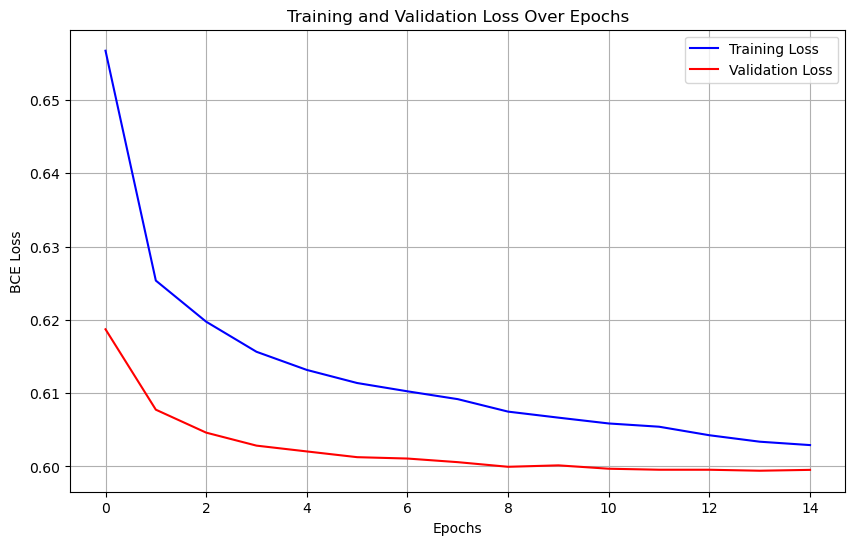

In [355]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.show() # Displays the chart after training is complete

In [356]:
all_labels = []
all_preds = []

# Ensure model is on the correct device (CPU or GPU)
model.eval() 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        # _, preds = torch.max(outputs, 1) # Get the predicted class index
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        
        # Move to CPU and convert to NumPy for sklearn compatibility
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [357]:
from sklearn.metrics import classification_report

# Print a comprehensive summary per class
report = classification_report(all_labels, all_preds)
print(report)

# For a single score across the whole dataset
final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.72      0.74      0.73     82230
           1       0.60      0.57      0.59     56081

    accuracy                           0.67    138311
   macro avg       0.66      0.66      0.66    138311
weighted avg       0.67      0.67      0.67    138311

Final Test Accuracy: 67.48%
